In [4]:
import os
import json
import zipfile
import subprocess
import tensorflow as tf

class ColabSetup:
    def __init__(self, kaggle_username, kaggle_key):
        self.kaggle_credentials = {
            "username": kaggle_username,
            "key": kaggle_key
        }

    def install_libraries(self):
        # Install the required libraries
        print("Installing required libraries...")
        subprocess.run(['pip', 'install', 'fastai', 'kaggle'])
        subprocess.run(['pip', 'install', 'matplotlib', 'scikit-learn', '-U', 'segmentation-models', 'patchify', 'Pillow'])
        print("Libraries installed successfully.")

    def setup_kaggle_credentials(self):
        # Write the kaggle.json file
        print("Setting up Kaggle credentials...")
        with open('kaggle.json', 'w') as file:
            json.dump(self.kaggle_credentials, file)
        os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
        os.system('mv kaggle.json ~/.kaggle/')
        os.system('chmod 600 ~/.kaggle/kaggle.json')
        print("Kaggle credentials set up successfully.")

    def download_dataset(self, dataset_name, output_dir='/content/data'):
        # Download dataset from Kaggle
        print(f"Downloading dataset {dataset_name}...")
        os.makedirs(output_dir, exist_ok=True)
        os.system(f'kaggle datasets download -d {dataset_name} -p {output_dir}')

        # List files in the output directory to check the name of the downloaded file
        files = os.listdir(output_dir)
        print(f"Files in {output_dir}: {files}")

        # Find the zip file in the directory
        zip_file = None
        for file in files:
            if file.endswith('.zip'):
                zip_file = file
                break

        if zip_file:
            # Unzip the dataset
            print(f"Unzipping {zip_file}...")
            with zipfile.ZipFile(f'{output_dir}/{zip_file}', 'r') as zip_ref:
                zip_ref.extractall(output_dir)
            print(f"Dataset unzipped to {output_dir}.")
        else:
            print("No zip file found in the specified directory.")

    def check_tpu(self):
        # Check TensorFlow version and TPU availability
        print("Checking TensorFlow version...")
        print("TensorFlow version:", tf.__version__)

        print("Checking for available TPUs...")
        tpus = tf.config.list_physical_devices('TPU')
        print("TPUs:", tpus)

        if tpus:
            print("TPU is available.")
            resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
            tf.config.experimental_connect_to_cluster(resolver)
            strategy = tf.distribute.TPUStrategy(resolver)
            print("Using TPU Strategy:", strategy)
        else:
            print("No TPU detected. Ensure TPU runtime is enabled.")

# Usage
if __name__ == "__main__":
    # Initialize the class with Kaggle credentials
    kaggle_username = "tarekziad"
    kaggle_key = "40b30aa49d333ec3eeafe32b7584f421"

    colab_setup = ColabSetup(kaggle_username, kaggle_key)

    # Install libraries
    colab_setup.install_libraries()

    # Set up Kaggle credentials
    colab_setup.setup_kaggle_credentials()

    # Download and unzip the dataset
    dataset_name = 'humansintheloop/semantic-segmentation-of-aerial-imagery'
    colab_setup.download_dataset(dataset_name)

    # Check for TPU availability and set up TPU strategy
    colab_setup.check_tpu()


Installing required libraries...
Libraries installed successfully.
Setting up Kaggle credentials...
Kaggle credentials set up successfully.
Files in /content/data: ['Semantic segmentation dataset', 'semantic-segmentation-of-aerial-imagery.zip']
Unzipping semantic-segmentation-of-aerial-imagery.zip...
Dataset unzipped to /content/data.
Checking TensorFlow version...
TensorFlow version: 2.15.0
Checking for available TPUs...
TPUs: [PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]
TPU is available.
Using TPU Strategy: <

# **Patchify images and masks**

Segmentation Models: using `tf.keras` framework.
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_001.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_002.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_003.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_004.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_005.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_006.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_007.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_008.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_009.jpg
Now patchifying image: /content/data/Semantic segme

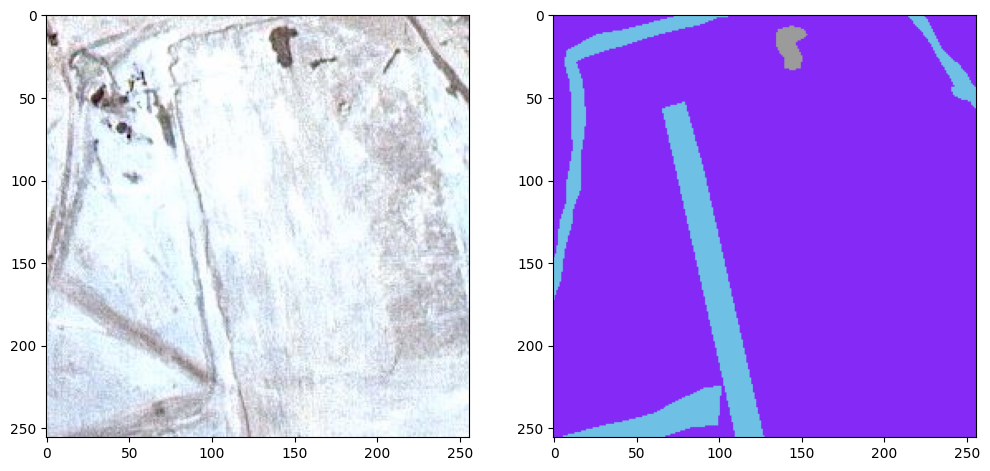

60
Unique labels in label dataset are:  [0 1 2 3 4 5]


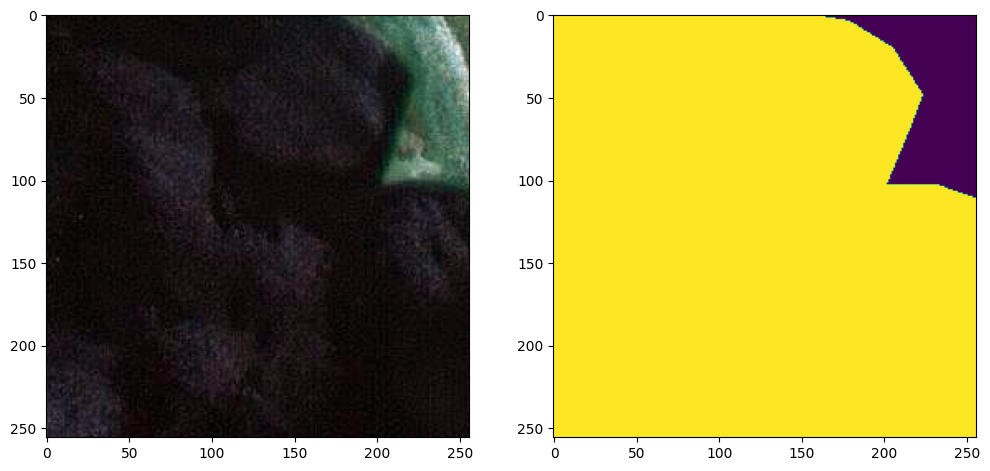

In [5]:
import os
import cv2
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
root_directory = "/content/data/Semantic segmentation dataset"

scaler = MinMaxScaler()
patch_size = 256
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images

                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
print("Number of images in dataset:", len(image_dataset))
print("Number of masks in dataset:", len(mask_dataset))
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


In [7]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

## **Build the U-Net model**

In [8]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [10]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/30
66/66 [==============================] - 108s 2s/step - loss: 0.9600 - accuracy: 0.7095 - jacard_coef: 0.4481 - val_loss: 0.9629 - val_accuracy: 0.7018 - val_jacard_coef: 0.4462
Epoch 2/30
66/66 [==============================] - 107s 2s/step - loss: 0.9486 - accuracy: 0.7440 - jacard_coef: 0.5029 - val_loss: 0.9606 - val_accuracy: 0.7041 - val_jacard_coef: 0.4810
Epoch 3/30
66/66 [==============================] - 106s 2s/step - loss: 0.9440 - accuracy: 0.7534 - jacard_coef: 0.5235 - val_loss: 0.9631 - val_accuracy: 0.6973 - val_jacard_coef: 0.4751
Epoch 4/30
66/66 [==============================] - 107s 2s/step - loss: 0.9414 - accuracy: 0.7592 - jacard_coef: 0.5362 - val_loss: 0.9541 - val_accuracy: 0.7220 - val_jacard_coef: 0.5110
Epoch 5/30
66/66 [==============================] - 107s 2s/step - loss: 0.9337 - accuracy: 0.7860 - jacard_coef: 0.5754 - val_loss: 0.9464 - val_accuracy: 0.7456 - val_jacard_coef: 0.5474
Epoch 6/30
66/66 [==============================] - 107

In [11]:
path_model = '/content/data/working/satellite_standard_unetBayes1_100epochs.hdf5'
model.save(path_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model_path =path_model


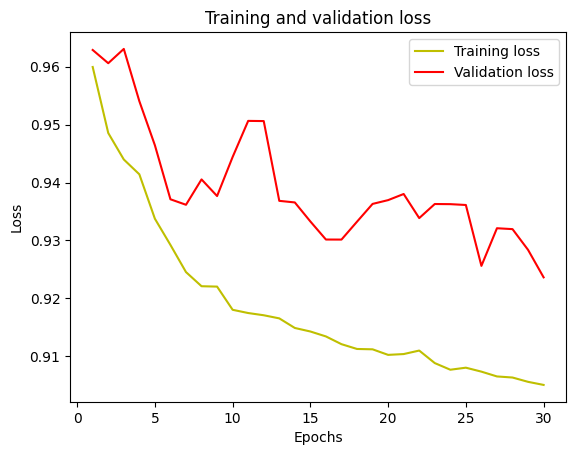

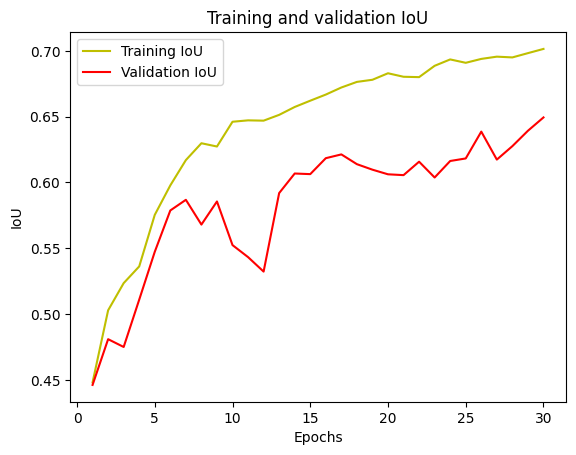

In [15]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

In [22]:
import os
import cv2
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [25]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import custom_object_scope

# Ensure you have TensorFlow environment variable set
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Define custom loss functions
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_loss_plus_focal_loss(y_true, y_pred):
    # Replace with the actual implementation of the combined loss
    # Here is a dummy example of how you might combine Dice and Focal Loss
    dice_loss = 1 - jacard_coef(y_true, y_pred)  # Example of Dice loss
    focal_loss = K.binary_crossentropy(y_true, y_pred)  # Placeholder for Focal loss
    return dice_loss + focal_loss  # Combine both losses

# Define MRF_layer
class MRF_layer(Layer):
    def __init__(self, n_classes, **kwargs):
        self.n_classes = n_classes
        super(MRF_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1, 1, input_shape[-1], self.n_classes),
                                      initializer='uniform',
                                      trainable=True)
        super(MRF_layer, self).build(input_shape)

    def call(self, x):
        return K.conv2d(x, self.kernel, strides=(1, 1), padding='same')

# Define custom objects
custom_objects = {
    "dice_loss_plus_1focal_loss": dice_loss_plus_focal_loss,  # Ensure this matches the name used during model compilation
    "jacard_coef": jacard_coef,
    "MRF_layer": MRF_layer
}

# Load the model with custom objects
with custom_object_scope(custom_objects):
    model = load_model(model_path, custom_objects=custom_objects)


9/9 [==============================] - 3s 349ms/step
Mean IoU = 0.5225096
1/1 [==============================] - 0s 51ms/step


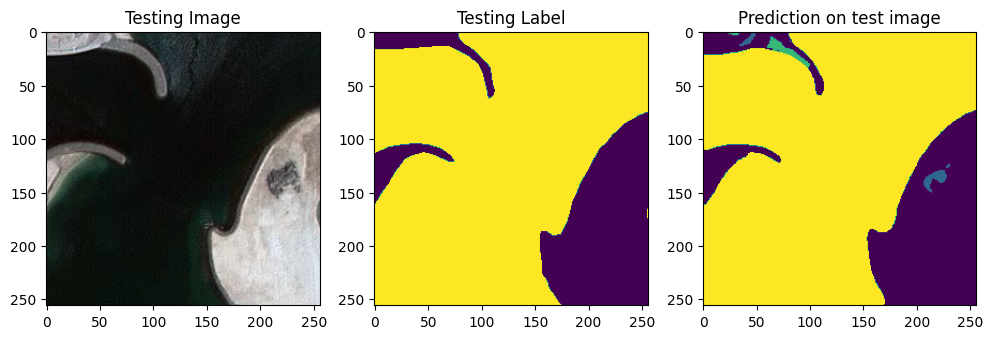

Mean IoU = 0.5225096
Dice Coefficient = 0.63390636
Precision = 0.8256199281334451
Recall = 0.8084647226150922
F1 Score = 0.8046988640268695
Pixel Accuracy = 0.8084647


In [27]:

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
# Number of images to predict
num_images = 5



import tensorflow as tf
from keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# Define number of classes
n_classes = 6

# IoU Metric
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())


import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Convert to one-hot encoding if not already (assuming y_true, y_pred are integer class labels)
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)

    # Flatten the one-hot encoded tensors for each class
    y_true_flat = tf.reshape(y_true_one_hot, [-1, n_classes])
    y_pred_flat = tf.reshape(y_pred_one_hot, [-1, n_classes])

    # Compute Dice Coefficient per class and then average
    intersection = tf.reduce_sum(tf.cast(y_true_flat * y_pred_flat, tf.float32), axis=0)
    union = tf.reduce_sum(tf.cast(y_true_flat, tf.float32), axis=0) + tf.reduce_sum(tf.cast(y_pred_flat, tf.float32), axis=0)

    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    dice_mean = tf.reduce_mean(dice_per_class)  # Average Dice coefficient across all classes

    return dice_mean

# Example usage
dice = dice_coefficient(y_test_argmax, y_pred_argmax)
print("Dice Coefficient =", dice.numpy())


# Precision and Recall
precision = precision_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
recall = recall_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
print("Precision =", precision)
print("Recall =", recall)

# F1 Score
f1 = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')
print("F1 Score =", f1)


import tensorflow as tf

def pixel_accuracy(y_true, y_pred):
    # Ensure both tensors are of the same type, here they're int64
    y_true = tf.cast(y_true, tf.int64)  # Make sure both are int64
    y_pred = tf.cast(y_pred, tf.int64)

    # Compute accuracy
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.float32)  # Make sure the size is float for division
    return correct / total

# Example usage
accuracy = pixel_accuracy(y_test_argmax, y_pred_argmax)
print("Pixel Accuracy =", accuracy.numpy())


